In [33]:
pip install spacy pandas numpy jiwer scikit-learn matplotlib


  Using cached matplotlib-3.9.2-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp312-cp312-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached pillow-10.4.0-cp312-cp312-win_amd64.whl.metadata (9.3 kB)
  Using cached pyparsing-3.1.4-py3-none-any.whl.metadata (5.1 kB)
Using cached matplotlib-3.9.2-cp312-cp312-win_amd64.whl (7.8 MB)
Using cached contourpy-1.3.0-cp312-cp312-win_amd64.whl (218 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 24.8 MB/s eta 0:00:00
Using cached pillow-10.4.0-cp312-cp312-win_amd64.whl (2.6 MB)
Using cached pyparsing-3.1.4-py3-none-any.whl (104 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
#Donwload the models

!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_lg
!python -m spacy download en_core_web_trf



     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------- ------------------ 6.8/12.8 MB 34.9 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 31.5 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 31.5 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 17.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ---------------------------------------- 0.0/587.7 MB ? eta -:--:--
     --------------------------------------- 6.8/587.7 MB 42.0 MB/s eta 0:00:14
      ------------------------------------- 12.1/587.7 MB 30.2 MB/s eta 0:00:20
     - ------------------------------------ 17.8/587.7 MB 29.6 MB/s eta 0:00:20
     - ------------------------------------ 24.6/587.7 MB 30.6 MB/s eta 0:00:19
     -- ----------------------------------- 32.5/587.7 MB 32.2 MB/s eta 0:00:18
     -- --------------------------

# 1.0 Using Spacy NER by default wihout Fine_Tuning to get a WER baseline


## 1.1 Using en_core_web_sm as Languaje Model 

In [4]:
# Import the required libraries
import pandas as pd
import spacy
import re
import string


file_path = '../data/Train_1.csv'
data = pd.read_csv(file_path)
data = data.dropna(subset=['text'])

# Load the SpaCy language model
model = spacy.load('en_core_web_sm')

def preprocess_tweet(text):
    if pd.isna(text):
        return ""
    # Convert text to lowercase
    #text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove @ mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (optional, keeping the hashtag content)
    text = re.sub(r'#', '', text)
    # Remove punctuation and numbers
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove non-ASCII characters (optional)
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    # Remove stopwords and lemmatize (using SpaCy)
    doc = model(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# Apply preprocessing function to the 'text' column
data['cleaned_text'] = data['text'].apply(preprocess_tweet)

# Function to extract locations (GPE) from text
def extract_locations(text):
    if pd.isna(text):
        return []
    doc = model(text)
    locations = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
    
    return ' '.join(set(locations))

# Apply the location extraction to the 'text' column
data['extracted_locations'] = data['cleaned_text'].apply(extract_locations)

# Display the tweets with extracted locations
data[['text', 'extracted_locations']].head()


,text,extracted_locations
1,"Flash floods struck a Maryland city on Sunday,...",Maryland
2,State of emergency declared for Maryland flood...,Maryland
3,Other parts of Maryland also saw significant d...,Maryland Baltimore
4,"Catastrophic Flooding Slams Ellicott City, Mar...",
5,WATCH: 1 missing after flash #FLOODING devasta...,Ellicott City Maryland


In [5]:
data[['text', 'extracted_locations']].head(20)

,text,extracted_locations
1,"Flash floods struck a Maryland city on Sunday,...",Maryland
2,State of emergency declared for Maryland flood...,Maryland
3,Other parts of Maryland also saw significant d...,Maryland Baltimore
4,"Catastrophic Flooding Slams Ellicott City, Mar...",
5,WATCH: 1 missing after flash #FLOODING devasta...,Ellicott City Maryland
14,Watch Live: Aerials of damage after historic f...,Maryland Ellicott City
17,One person is reported missing as a state of e...,Maryland
18,Monday May 28 - Morning Report: National Guard...,Maryland Trump Arlington
20,One man is still missing after flash flooding ...,
21,RT @KCCINews: State of emergency declared in M...,Maryland


### 1.1.1 Calculating WER with en_core_web_sm

In [7]:
from jiwer import wer

# Function to calculate Word Error Rate (WER)
def calculate_wer(row):
    if not row['location'] or not row['extracted_locations']:
        return 1.0  # If either is empty, consider it a complete error
   
    # Use WER function from jiwer package
    return wer(str(row['location']), str(row['extracted_locations']))

# Apply the WER function to compare the 'location' and 'extracted_locations'
data['wer'] = data.apply(calculate_wer, axis=1)

# Display the WER for the first few rows
data[['location', 'extracted_locations', 'wer']].head()

#Get the average WER
average_wer = data['wer'].mean()
print(f"Average Word Error Rate (WER): {average_wer:.4f}")

#Get the accuracy
accuracy = 1 - average_wer  
print(f"Accuracy: {accuracy:.4f}")



Average Word Error Rate (WER): 0.6911
Accuracy: 0.3089


## 1.2 Using en_core_web_lg as Languaje Model 

In [8]:
# Import the required libraries
import pandas as pd
import spacy
import re
import string


file_path = '../data/Train_1.csv'
data = pd.read_csv(file_path)
data = data.dropna(subset=['text'])

# Load the SpaCy language model
model = spacy.load('en_core_web_lg')

def preprocess_tweet(text):
    if pd.isna(text):
        return ""
    # Convert text to lowercase
    #text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove @ mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags  (optional, keeping the hashtag content)
    text = re.sub(r'#', '', text)
    # Remove punctuation and numbers
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove non-ASCII characters (optional)
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    # Remove stopwords and lemmatize (using SpaCy)
    doc = model(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# Apply preprocessing function to the 'text' column
data['cleaned_text'] = data['text'].apply(preprocess_tweet)

# Function to extract locations (GPE) from text
def extract_locations(text):
    if pd.isna(text):
        return []
    doc = model(text)
    locations = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
    
    return ' '.join(set(locations))

# Apply the location extraction to the 'text' column
data['extracted_locations'] = data['cleaned_text'].apply(extract_locations)

# Display the tweets with extracted locations
data[['text', 'extracted_locations']].head()


,text,extracted_locations
1,"Flash floods struck a Maryland city on Sunday,...",Maryland
2,State of emergency declared for Maryland flood...,Maryland
3,Other parts of Maryland also saw significant d...,Maryland Dundalk Baltimore
4,"Catastrophic Flooding Slams Ellicott City, Mar...",
5,WATCH: 1 missing after flash #FLOODING devasta...,Ellicott City Maryland


### 1.2.1 Calculating WER with en_core_web_lg

In [9]:
from jiwer import wer

# Function to calculate Word Error Rate (WER)
def calculate_wer(row):
    if not row['location'] or not row['extracted_locations']:
        return 1.0  # If either is empty, consider it a complete error
   
    # Use WER function from jiwer package
    return wer(str(row['location']), str(row['extracted_locations']))

# Apply the WER function to compare the 'location' and 'extracted_locations'
data['wer'] = data.apply(calculate_wer, axis=1)

# Display the WER for the first few rows
data[['location', 'extracted_locations', 'wer']].head()

#Get the average WER
average_wer = data['wer'].mean()
print(f"Average Word Error Rate (WER): {average_wer:.4f}")

#Get the accuracy
accuracy = 1 - average_wer  
print(f"Accuracy: {accuracy:.4f}")



Average Word Error Rate (WER): 0.7340
Accuracy: 0.2660


### 1.3 Using en_core_web_trf as Languaje Model 

In [22]:
# Import the required libraries
import pandas as pd
import spacy
import re
import string


file_path = '../data/Train_1.csv'
data = pd.read_csv(file_path)
data = data.dropna(subset=['text'])

# Load the SpaCy language model
model = spacy.load('en_core_web_trf')

def preprocess_tweet(text):
    if pd.isna(text):
        return ""
    # Convert text to lowercase
    #text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove @ mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (optional, keeping the hashtag content)
    text = re.sub(r'#', '', text)
    # Remove punctuation and numbers
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove non-ASCII characters (optional)
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    # Remove stopwords and lemmatize (using SpaCy)
    doc = model(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# Apply preprocessing function to the 'text' column
data['cleaned_text'] = data['text'].apply(preprocess_tweet)

# Function to extract locations (GPE) from text
def extract_locations(text):
    if pd.isna(text):
        return []
    doc = model(text)
    locations = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
    
    return ' '.join(set(locations))

# Apply the location extraction to the 'text' column
data['extracted_locations'] = data['cleaned_text'].apply(extract_locations)

# Display the tweets with extracted locations
data[['text', 'extracted_locations']].head()


c:\Users\HP\OneDrive\Documents\Eduardo Toledo\ASAI\ai4good_location_mention_recognition\.venv\Lib\site-packages\thinc\shims\pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimenta

,text,extracted_locations
1,"Flash floods struck a Maryland city on Sunday,...",Maryland
2,State of emergency declared for Maryland flood...,Maryland
3,Other parts of Maryland also saw significant d...,Dundalk Catonsville Maryland Baltimore
4,"Catastrophic Flooding Slams Ellicott City, Mar...",Maryland Ellicott City
5,WATCH: 1 missing after flash #FLOODING devasta...,Maryland Ellicott City


### 1.3.1 Calculating WER with en_core_web_trf

In [23]:
# Apply the WER function to compare the 'location' and 'extracted_locations'
data['wer'] = data.apply(calculate_wer, axis=1)

# Display the WER for the first few rows
data[['location', 'extracted_locations', 'wer']].head()

#Get the average WER
average_wer = data['wer'].mean()
print(f"Average Word Error Rate (WER): {average_wer:.4f}")

#Get the accuracy
accuracy = 1 - average_wer  
print(f"Accuracy: {accuracy:.4f}")


Average Word Error Rate (WER): 0.6297
Accuracy: 0.3703


# 2.0- Spacy Fine Tuning For NER 


## 2.1 Convert Training Dataset to Spacy Format

In [28]:
import spacy
from spacy.tokens import DocBin


model = spacy.load("en_core_web_sm")

LABEL = 'GPE'
# Function to remove overlapping entities
def remove_overlapping_entities(entities):
    entities = sorted(entities, key=lambda x: x[0])  # Sort by start position
    unique_entities = []
    last_end = -1
    for start, end, label in entities:
        if start >= last_end:  # Ensure no overlap
            unique_entities.append((start, end, label))
            last_end = end
    return unique_entities

# Convert the data into SpaCy's format and add to DocBin
def convert_to_spacy_format(row):
    text = row['cleaned_text']
    locations = row['location']  # Multiple locations might be separated by spaces
    
    if pd.isna(text) or pd.isna(locations):
        return None
    
    entities = []
    for loc in locations.split(" "):  # Split locations by spaces
        loc = loc.strip()
        start = text.lower().find(loc.lower())  # Case-insensitive search
        if start != -1:
            end = start + len(loc)
            entities.append((start, end, LABEL))  # Annotate the location as GPE
    
    entities = remove_overlapping_entities(entities)
    return (text, {"entities": entities})

# Initialize a DocBin to store the training data
db = DocBin()

# Process each row and create SpaCy documents with entities
for idx, row in data.iterrows():
    spacy_format = convert_to_spacy_format(row)
    if spacy_format is not None:
        text, annotations = spacy_format
        doc = model(text)
        ents = []
        for start, end, label in annotations['entities']:
            span = doc.char_span(start, end, label=label)
            if span is not None:  # Ensure valid token boundaries
                ents.append(span)
        doc.ents = ents  # Assign the entities to the doc
        db.add(doc)  # Add the doc to the DocBin

# Save the DocBin to disk in .spacy format
db.to_disk("./train.spacy")




### 2.2 Split Train on Training and Validation 

In [24]:
import spacy
from spacy.tokens import DocBin
from sklearn.model_selection import train_test_split

model = spacy.load("en_core_web_sm")
# Load the data from the .spacy file
doc_bin = DocBin().from_disk("./train.spacy")

# Get the docs from the DocBin
docs = list(doc_bin.get_docs(model.vocab))

# Split the docs into training and validation sets (80% train, 20% validation)
train_docs, val_docs = train_test_split(docs, test_size=0.2, random_state=42, shuffle=True)

# Create two new DocBin objects, one for training and one for validation
train_doc_bin = DocBin()
val_doc_bin = DocBin()

# Add the split docs to the respective DocBin
for doc in train_docs:
    train_doc_bin.add(doc)
    
for doc in val_docs:
    val_doc_bin.add(doc)

# Save the new training and validation sets to separate .spacy files
train_doc_bin.to_disk("./train_split.spacy")
val_doc_bin.to_disk("./validation_split.spacy")




### 2.3 Set Up the Fine-Tuning Pipeline in SpaCy model (en_core_web_sm)


Epoch 1 - Training Loss: 9396.77102299979 | Validation Loss: 2069.154221357002
Validation Score: {'token_acc': 1.0, 'token_p': 1.0, 'token_r': 1.0, 'token_f': 1.0, 'ents_p': 0.8994950709305122, 'ents_r': 1.0, 'ents_f': 0.9470886075949367, 'ents_per_type': {'GPE': {'p': 0.8994950709305122, 'r': 1.0, 'f': 0.9470886075949367}}, 'speed': 15787.843153814129}
Epoch 2 - Training Loss: 8274.949420230441 | Validation Loss: 1932.4000600340653
Validation Score: {'token_acc': 1.0, 'token_p': 1.0, 'token_r': 1.0, 'token_f': 1.0, 'ents_p': 0.8814797360980208, 'ents_r': 1.0, 'ents_f': 0.9370068879148403, 'ents_per_type': {'GPE': {'p': 0.8814797360980208, 'r': 1.0, 'f': 0.9370068879148403}}, 'speed': 17728.679359085007}
Epoch 3 - Training Loss: 8013.452541551808 | Validation Loss: 1851.7677796743064
Validation Score: {'token_acc': 1.0, 'token_p': 1.0, 'token_r': 1.0, 'token_f': 1.0, 'ents_p': 0.9003610108303249, 'ents_r': 1.0, 'ents_f': 0.9475683890577509, 'ents_per_type': {'GPE': {'p': 0.900361010830

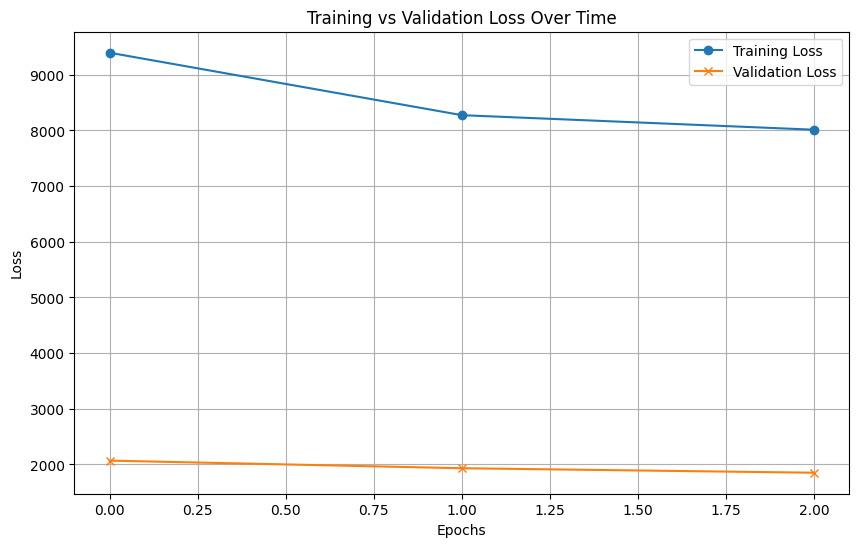

In [25]:
import spacy
from spacy.training.example import Example
from spacy.tokens import DocBin
from pathlib import Path
import random
import matplotlib.pyplot as plt



# Load the base model
model = spacy.load("en_core_web_lg")

# Load the training data from .spacy file
def load_spacy_data(file_path):
    doc_bin = DocBin().from_disk(file_path)
    return list(doc_bin.get_docs(model.vocab))

# Load training and validation data
train_data = load_spacy_data("./train_split.spacy")
valid_data = load_spacy_data("./validation_split.spacy")

# Function to evaluate the model on validation data
def evaluate_model(model, data):
    examples = [Example.from_dict(doc, {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}) for doc in data]
    scorer = model.evaluate(examples)
    return scorer

# Function to calculate validation loss (NLL)
def calculate_validation_loss(nlp, data):
    losses = {}
    for doc in data:
        example = Example.from_dict(doc, {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]})
        # Compute loss without updating model
        nlp.update([example], sgd=None, losses=losses, drop=0)
    return sum(losses.values())
train_losses = []
val_losses = []

# Disable pipeline components that we don't want to update
pipe_exceptions = ["ner"]  # Only train the NER component
other_pipes = [pipe for pipe in model.pipe_names if pipe not in pipe_exceptions]
with model.disable_pipes(*other_pipes):  # Only train NER
    optimizer = model.resume_training()
    #optimizer.learn_rate = 0.00005

    # Number of training epochs
    for epoch in range(3):  # Adjust the number of epochs as needed
        losses = {}

        # Shuffle the training data for each epoch
        random.shuffle(train_data)

        # Update the model with the training data
        for doc in train_data:
            example = Example.from_dict(doc, {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]})
            model.update([example], drop=0.15, losses=losses)

          # Get validation loss after each epoch
        val_loss = calculate_validation_loss(model, valid_data)
      
        train_loss = sum(losses.values())
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch + 1} - Training Loss: {train_loss} | Validation Loss: {val_loss}")
        scorer = evaluate_model(model, valid_data)
        print(f"Validation Score: {scorer}")
scorer = evaluate_model(model, valid_data)
print(f"Final Validation Score: {scorer}")

# Save the fine-tuned model
model.to_disk("./fine_tuned_ner_model_lg")



# Visualize the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()




token_acc, token_p, token_r, token_f:
These metrics relate to the token-level accuracy of the model, meaning how well the model is identifying tokens correctly.

token_acc (Token Accuracy):

This is the proportion of tokens that were correctly identified by the model (i.e., the correct number of tokens are predicted).
1.0 indicates 100% accuracy, meaning that the model predicted every token boundary correctly.
token_p (Token Precision):

This measures how many of the tokens identified by the model are actually correct (true positives / (true positives + false positives)).
1.0 means every token the model identified was correct.
token_r (Token Recall):

This measures how many of the actual tokens were correctly identified by the model (true positives / (true positives + false negatives)).
1.0 means the model found all the actual tokens correctly.
token_f (Token F1-Score):

This is the harmonic mean of token precision and recall, giving a balance between the two.
1.0 indicates perfect F1-score for token-level predictions.
2. ents_p, ents_r, ents_f:
These metrics relate to the entity-level precision, recall, and F1-score for the Named Entity Recognition (NER) task. This is more relevant for your task of location (GPE) recognition.

ents_p (Entity Precision):

0.8407 indicates that 84.07% of the entities predicted by the model were correct. This means that the model sometimes predicted false positives (entities that don't exist in the actual data).
ents_r (Entity Recall):

1.0 indicates that the model found 100% of the actual entities (no false negatives). In other words, it successfully identified all the actual GPE entities in the validation data.
ents_f (Entity F1-Score):

0.9134 indicates that the overall balance of precision and recall for entity recognition is 91.34%. This score balances how many entities were found (recall) with how many of the identified entities were correct (precision).
3. ents_per_type:
This section gives more granular details about the performance of the model for each entity type. In your case, you're training the model to recognize GPE entities.

GPE (Geopolitical Entities):
p (Precision): 0.8407 – The model correctly identified 84.07% of the GPE entities.
r (Recall): 1.0 – The model found all of the actual GPE entities.
f (F1-Score): 0.9134 – The balance between precision and recall for GPE entities is 91.34%.



Summary:
Token-level performance: The model has perfect accuracy at the token level (token_acc = 1.0), meaning it correctly identifies all the tokens in the text.
Entity-level performance:
Precision for GPE entities is 84.07%, meaning there are some false positives.
Recall is 100%, meaning the model correctly identified all GPE entities in the validation set.
F1-Score is 91.34%, showing a good balance between precision and recall.
.
Interpretation:
The model has high recall (100%) but lower precision (84.07%), indicating that while the model finds all GPE entities, it may also identify some false positives. The F1-score of 91.34% shows a strong performance for entity recognition.
If you want to improve the model, you might focus on reducing false positives to increase precision.

Testing the Fine-Tuned Model:

In [26]:
# Import the required libraries
import pandas as pd
import spacy
import re
import string


file_path = '../data/Train_1.csv'
data = pd.read_csv(file_path)
data = data.dropna(subset=['text'])

# Load the SpaCy language model
model = spacy.load('fine_tuned_ner_model_sm')

def preprocess_tweet(text):
    if pd.isna(text):
        return ""
    # Convert text to lowercase
    #text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove @ mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (optional, keeping the hashtag content)
    text = re.sub(r'#', '', text)
    # Remove punctuation and numbers
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove non-ASCII characters (optional)
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    # Remove stopwords and lemmatize (using SpaCy)
    doc = model(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# Apply preprocessing function to the 'text' column
data['cleaned_text'] = data['text'].apply(preprocess_tweet)

# Function to extract locations (GPE) from text
def extract_locations(text):
    if pd.isna(text):
        return []
    doc = model(text)
    locations = [ent.text for ent in doc.ents if ent.label_ == 'GPE']
    
    return ' '.join(set(locations))

# Apply the location extraction to the 'text' column
data['extracted_locations'] = data['cleaned_text'].apply(extract_locations)

# Display the tweets with extracted locations
data[['text', 'extracted_locations']].head()


,text,extracted_locations
1,"Flash floods struck a Maryland city on Sunday,...",Maryland
2,State of emergency declared for Maryland flood...,Maryland
3,Other parts of Maryland also saw significant d...,Dundalk Baltimore Catonsville Maryland
4,"Catastrophic Flooding Slams Ellicott City, Mar...",City Ellicott Maryland
5,WATCH: 1 missing after flash #FLOODING devasta...,City Ellicott Maryland


In [27]:
from jiwer import wer

# Function to calculate Word Error Rate (WER)
def calculate_wer(row):
    if not row['location'] or not row['extracted_locations']:
        return 1.0  # If either is empty, consider it a complete error
   
    # Use WER function from jiwer package
    return wer(str(row['location']), str(row['extracted_locations']))

# Apply the WER function to compare the 'location' and 'extracted_locations'
data['wer'] = data.apply(calculate_wer, axis=1)

# Display the WER for the first few rows
data[['location', 'extracted_locations', 'wer']].head()

#Get the average WER
average_wer = data['wer'].mean()
print(f"Average Word Error Rate (WER): {average_wer:.4f}")

#Get the accuracy
accuracy = 1 - average_wer  
print(f"Accuracy: {accuracy:.4f}")



Average Word Error Rate (WER): 0.5471
Accuracy: 0.4529


SM:
Average Word Error Rate (WER): 0.5664
Accuracy: 0.4336
LG:
Average Word Error Rate (WER): 0.5471
Accuracy: 0.4529




2.4 Generar submission

In [30]:
# Import the required libraries
import pandas as pd
import spacy
import re
import string


file_path = '../data/Test.csv'
data = pd.read_csv(file_path)
#data = data.dropna(subset=['text'])

# Load the SpaCy language model
model = spacy.load('fine_tuned_ner_model_sm')

def preprocess_tweet(text):
    if pd.isna(text):
        return ""
    # Convert text to lowercase
    #text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove @ mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (optional, keeping the hashtag content)
    text = re.sub(r'#', '', text)
    # Remove punctuation and numbers
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove non-ASCII characters (optional)
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    # Remove stopwords and lemmatize (using SpaCy)
    doc = model(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# Apply preprocessing function to the 'text' column
data['cleaned_text'] = data['text'].apply(preprocess_tweet)

# Function to extract locations (GPE) from text
def extract_locations(text):
    if pd.isna(text):
        return []
    doc = model(text)
    locations = [ent.text for ent in doc.ents if (ent.label_ == 'GPE')]
    if locations:
        return ' '.join(set(locations))
    else:
        return None

def extract_ner(text):
    doc = model(text)
    entities = [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    if entities:
        return entities
    else:
        return None  # Return None if no entities are found

# Apply the location extraction to the 'text' column
data['location'] = data['cleaned_text'].apply(extract_locations)


# Display the tweets with extracted locations
data[['text', 'location']].head()

# Drop the 'text' column from the test data
#data = data.drop(columns=['text'])
data = data.drop(columns=['cleaned_text'])
# Save the test data with extracted locations to a new CSV file
data.to_csv("../data/submission_et.csv", index=False)

#get the  locations  with na or location == ' '
# Get the number of empty entries in the 'location' column

empty_entries = data[data['location'].isna()]
len(empty_entries)


278

In [31]:
empty_entries.to_csv("../data/empty_entries.csv", index=False)

 Creating Location Patterns for the Entity Ruler

In [40]:
import spacy
from spacy.pipeline import EntityRuler

# Load the fine-tuned transformer-based model
nlp = spacy.load("fine_tuned_ner_model_sm")

# Initialize the EntityRuler and define patterns
ruler = nlp.add_pipe("entity_ruler", before="ner")

# Define location patterns (GPE: Geopolitical Entity)
patterns = [
    {"label": "GPE", "pattern": "Greek"},
    {"label": "GPE", "pattern": "greek"},
    {"label": "GPE", "pattern": "Greece"},
    {"label": "GPE", "pattern": "greece"},
    {"label": "GPE", "pattern": "Greeces"},
    {"label": "GPE", "pattern": "puertorico"},
    {"label": "GPE", "pattern": "greeces"},
    {"label": "GPE", "pattern": "KeralaFloods"},
    {"label": "GPE", "pattern": "LA"},
    {"label": "GPE", "pattern": "mozambique"},
    
    
    
    # Add more location patterns as needed
]

# Add patterns to the EntityRuler
ruler.add_patterns(patterns)

# Save the updated pipeline with the EntityRuler added
nlp.to_disk("fine_tuned_ner_model_sm_with_ruler")

In [43]:
# Import the required libraries
import pandas as pd
import spacy
import re
import string


file_path = '../data/Test.csv'
data = pd.read_csv(file_path)
#data = data.dropna(subset=['text'])

# Load the SpaCy language model
model = spacy.load('fine_tuned_ner_model_sm_with_ruler')

def preprocess_tweet(text):
    if pd.isna(text):
        return ""
    # Convert text to lowercase
    #text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove @ mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (optional, keeping the hashtag content)
    text = re.sub(r'#', '', text)
    # Remove punctuation and numbers
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove non-ASCII characters (optional)
    text = re.sub(r'[^\x00-\x7f]', r'', text)
    # Remove stopwords and lemmatize (using SpaCy)
    doc = model(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# Apply preprocessing function to the 'text' column
data['cleaned_text'] = data['text'].apply(preprocess_tweet)

# Function to extract locations (GPE) from text
def extract_locations(text):
    if pd.isna(text):
        return []
    doc = model(text)
    locations = [ent.text for ent in doc.ents if (ent.label_ == 'GPE')]
    if locations:
        return ' '.join(set(locations))
    else:
        return "None"

def extract_ner(text):
    doc = model(text)
    entities = [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
    if entities:
        return entities
    else:
        return "None"  # Return None if no entities are found

# Apply the location extraction to the 'text' column
data['location'] = data['cleaned_text'].apply(extract_locations)


# Display the tweets with extracted locations
data[['text', 'location']].head()

# Drop the 'text' column from the test data
data = data.drop(columns=['text'])
data = data.drop(columns=['cleaned_text'])
# Save the test data with extracted locations to a new CSV file
data.to_csv("../data/submission_et.csv", index=False)

#get the  locations  with na or location == ' '
# Get the number of empty entries in the 'location' column

empty_entries = data[data['location'].isna()]
len(empty_entries)


0

In [39]:
empty_entries.to_csv("../data/empty_entries.csv", index=False)